### Name   : Raafi Dimas Adji Pradana
### Course : DICODING

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [34]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
data = pd.read_csv('/content/drive/MyDrive/Datacolab/Sentiment.csv')

In [5]:
# Keeping only the neccessary columns
data = data[['text','sentiment']]

In [6]:
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13871 entries, 0 to 13870
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       13871 non-null  object
 1   sentiment  13871 non-null  object
dtypes: object(2)
memory usage: 216.9+ KB


In [9]:
data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

4472
16986


In [11]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 28, 128)           256000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 28, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7510, 28) (7510, 2)
(3219, 28) (3219, 2)


In [14]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 15, batch_size=batch_size, verbose = 2)

Epoch 1/15
235/235 - 22s - loss: 0.1688 - accuracy: 0.9329
Epoch 2/15
235/235 - 22s - loss: 0.1486 - accuracy: 0.9381
Epoch 3/15
235/235 - 22s - loss: 0.1366 - accuracy: 0.9437
Epoch 4/15
235/235 - 22s - loss: 0.1269 - accuracy: 0.9462
Epoch 5/15
235/235 - 22s - loss: 0.1217 - accuracy: 0.9475
Epoch 6/15
235/235 - 22s - loss: 0.1140 - accuracy: 0.9525
Epoch 7/15
235/235 - 22s - loss: 0.1090 - accuracy: 0.9541
Epoch 8/15
235/235 - 22s - loss: 0.1054 - accuracy: 0.9579
Epoch 9/15
235/235 - 22s - loss: 0.0953 - accuracy: 0.9621
Epoch 10/15
235/235 - 22s - loss: 0.0933 - accuracy: 0.9598
Epoch 11/15
235/235 - 22s - loss: 0.0882 - accuracy: 0.9648
Epoch 12/15
235/235 - 22s - loss: 0.0884 - accuracy: 0.9601
Epoch 13/15
235/235 - 22s - loss: 0.0860 - accuracy: 0.9648
Epoch 14/15
235/235 - 22s - loss: 0.0829 - accuracy: 0.9638
Epoch 15/15
235/235 - 22s - loss: 0.0877 - accuracy: 0.9639


In [28]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [29]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 15, batch_size=batch_size, verbose = 2, validation_data=(X_test, Y_test), callbacks=[callbacks])

Epoch 1/15
235/235 - 22s - loss: 0.0630 - accuracy: 0.9715 - val_loss: 1.1395 - val_accuracy: 0.8232

Akurasi telah mencapai >90%!


In [39]:
hist = model.fit(X_train, Y_train, epochs = 15, batch_size=batch_size, verbose = 2, validation_data=(X_test, Y_test))

Epoch 1/15
235/235 - 22s - loss: 0.0657 - accuracy: 0.9712 - val_loss: 1.0735 - val_accuracy: 0.8208
Epoch 2/15
235/235 - 22s - loss: 0.0612 - accuracy: 0.9742 - val_loss: 1.1566 - val_accuracy: 0.8179
Epoch 3/15
235/235 - 22s - loss: 0.0629 - accuracy: 0.9744 - val_loss: 1.1874 - val_accuracy: 0.8133
Epoch 4/15
235/235 - 22s - loss: 0.0603 - accuracy: 0.9732 - val_loss: 1.2377 - val_accuracy: 0.8069
Epoch 5/15
235/235 - 22s - loss: 0.0662 - accuracy: 0.9718 - val_loss: 1.1413 - val_accuracy: 0.8185
Epoch 6/15
235/235 - 22s - loss: 0.0601 - accuracy: 0.9735 - val_loss: 1.2006 - val_accuracy: 0.8202
Epoch 7/15
235/235 - 22s - loss: 0.0625 - accuracy: 0.9724 - val_loss: 1.1205 - val_accuracy: 0.8162
Epoch 8/15
235/235 - 22s - loss: 0.0645 - accuracy: 0.9711 - val_loss: 1.1514 - val_accuracy: 0.8290
Epoch 9/15
235/235 - 22s - loss: 0.0649 - accuracy: 0.9720 - val_loss: 1.0262 - val_accuracy: 0.8185
Epoch 10/15
235/235 - 22s - loss: 0.0600 - accuracy: 0.9736 - val_loss: 1.1447 - val_accura

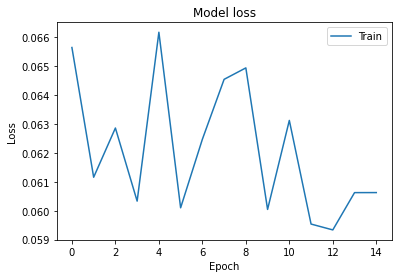

In [40]:
plt.plot(hist.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

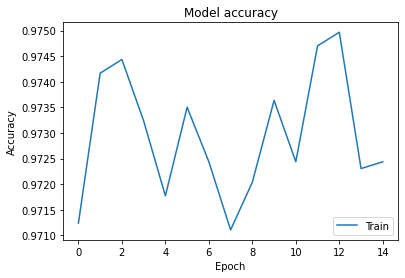

In [41]:
plt.plot(hist.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

In [30]:
Y_pred = model.predict_classes(X_test,batch_size = batch_size)
df_test = pd.DataFrame({'true': Y_test.tolist(), 'pred':Y_pred})
df_test['true'] = df_test['true'].apply(lambda x: np.argmax(x))
print('Confusion matrix\n',confusion_matrix(df_test.true, df_test.pred))
print(classification_report(df_test.true, df_test.pred))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion matrix
 [[1238  127]
 [ 177  177]]
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1365
           1       0.58      0.50      0.54       354

    accuracy                           0.82      1719
   macro avg       0.73      0.70      0.71      1719
weighted avg       0.81      0.82      0.82      1719

